In [2]:
# Import manipulating files libraries
import os, glob

# Import graph/image plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Import loading and manipulating neuroimaging data library
import nibabel as nib

# Import array manipulating libraries
import numpy as np
import pandas as pd

# Import deep learning model libraries
import keras
from keras.callbacks import TensorBoard
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Import date/time library to save models with date/time
from datetime import datetime

In [70]:
# Get data path
data_path = '../acerta_whole/ablation/*.nii.gz'
# Find all files within the location that matches our search string
files = glob.glob(data_path)

# Get the labels for our data from our csv file
labels = pd.read_csv('../data_aug/y_ablation.csv', sep=",")
# Define our target from the column "Labels" as our y in our model
target = labels['Labels']

In [71]:
# Loop through files and load all data files
data_all, images = [], []
for data_file in sorted(files):
    data = nib.load(data_file).get_fdata()
    # Here we remove one slice from all of our Nifti files due to noise in that slice
    new_img = np.delete(data, 18, axis=2)
    data_all.append(new_img)
    
# Convert our list into a numpy array
images = np.asarray(data_all)

print(len(data_all))

128


In [72]:
# Create list of indices
N = images.shape[0]
indexes = np.arange(N)

# Divide our dataset into dyslexics and controls to have a balanced train, validation and test sets
dis = indexes[:64]
con = indexes[64:]

#  Cut the dataset at 80% to create the training, 10% validation and 10% test set
size = dis.shape[0]
split_1 = int(0.8 * size)
split_2 = int(0.9 * size)

# Shuffle our dyslexics and controls arrays to create random indexes
np.random.shuffle(np.asarray(dis))
np.random.shuffle(np.asarray(con))

# Create our indexes for our train, validation and test sets according to our previous division (80%, 10%, 10%)
indexes_train_dis, indexes_train_con = dis[:split_1], con[:split_1]
indexes_val_dis, indexes_val_con   = dis[split_1:split_2], con[split_1:split_2]
indexes_test_dis, indexes_test_con = dis[split_2:], con[split_2:]

# We concatenate our training, validation and test indexes for dyslexics and controls
# By doing that we ensure that each set is balanced with the same number of dyslexics and controls
indexes_train = np.concatenate((indexes_train_dis, indexes_train_con), axis=None)
indexes_val = np.concatenate((indexes_val_dis, indexes_val_con), axis=None)
indexes_test = np.concatenate((indexes_test_dis, indexes_test_con), axis=None)


# Split the data into training, validation and test sets according to the indexes created previously
X_train = images[indexes_train, ...]
X_val = images[indexes_val, ...]
X_test = images[indexes_test, ...]

In [73]:
# Create outcome variable for each set (training, validation and test)
y_train = target[indexes_train] 
y_val   = target[indexes_val]
y_test  = target[indexes_test]

In [74]:
# We need to reformat the shape of our outcome variables, y_train, y_dev and y_test, because Keras needs the labels 
# as a 2D array. Keras provides a function to do this:

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Here we check the final distribution of our sets and its shape
# It is also possible to check if the labels became categorical (the second dimension in our arrays)
print(y_train.shape)
print(y_train[2])
print(y_test.shape)
print(y_val.shape)

(102, 2)
[0. 1.]
(14, 2)
(12, 2)


In [75]:
# Here we begin to create our sequential model

# Get shape of input data
data_shape = tuple(X_train.shape[1:])
# We check the shape of our data (Nifti files)
print(data_shape)

# Specify shape of convolution kernel
kernel_size = (3, 3)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 16

(60, 73, 60)


In [76]:
# Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers
K.clear_session()
# Set learning phase from our model to training
K.set_learning_phase(1)

# Create our Modified LeNet-5 model
model = Sequential()

# Add blocks of convolutional layers followed by batch normalization and pooling
model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=data_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters * 2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters * 4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Reshape the tensor to have the shape that is equal to the number of elements contained 
# in tensor non including the batch dimension
model.add(Flatten())

# Add the fully connected layer followed by a dropout of 50%
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# We finally add the softmax classifier to our model
model.add(Dense(n_classes, activation='softmax', name='preds'))

# Define the learning rate to our optimizer and which optimizer we will use
learning_rate = 1e-5
adam = Adam(lr=learning_rate)

# Here we configure the loss and metrics of our model
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 71, 16)        8656      
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 71, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 35, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 33, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 33, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 14, 64)       

In [77]:
# Fitting the Model

# The next step is now of course to fit our model to the training data. 
# In our case we have two parameters that we can work with:

# First: How many iterations of the model fitting should be computed
nEpochs = 200  # Increase this value for better results (i.e., more training)

# Second: How many elements (volumes) should be considered at once for the updating of the weights?

batch_size = 16   # Increasing this value might speed up fitting

In [78]:
# TensorBoard callback
# We define the directory for our tensorboard save each of our runs
LOG_DIRECTORY_ROOT = 'logdir'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

In [79]:
# Adding ModelCheckPoint callback
checkpointer = keras.callbacks.ModelCheckpoint(filepath='saved_models/best_model.hdf5', verbose=1, save_best_only=True)

# Place the callbacks in a list
callback_list = [tensorboard, checkpointer]

In [80]:
# Let's test the model:

%time fit = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nEpochs, batch_size=batch_size, verbose=1, callbacks=callback_list)

Train on 102 samples, validate on 12 samples
Epoch 1/200
102/102 [==============================] - 2s 17ms/step - loss: 1.8169 - accuracy: 0.4412 - val_loss: 2.4433 - val_accuracy: 0.4167

Epoch 00001: val_loss improved from inf to 2.44334, saving model to saved_models/best_model.hdf5
Epoch 2/200
102/102 [==============================] - 1s 11ms/step - loss: 1.4521 - accuracy: 0.5000 - val_loss: 1.8169 - val_accuracy: 0.4167

Epoch 00002: val_loss improved from 2.44334 to 1.81690, saving model to saved_models/best_model.hdf5
Epoch 3/200
102/102 [==============================] - 1s 11ms/step - loss: 1.3027 - accuracy: 0.4608 - val_loss: 3.2648 - val_accuracy: 0.4167

Epoch 00003: val_loss did not improve from 1.81690
Epoch 4/200
102/102 [==============================] - 1s 10ms/step - loss: 1.3180 - accuracy: 0.4706 - val_loss: 1.9306 - val_accuracy: 0.5833

Epoch 00004: val_loss did not improve from 1.81690
Epoch 5/200
102/102 [==============================] - 1s 10ms/step - loss:

102/102 [==============================] - 1s 11ms/step - loss: 0.6890 - accuracy: 0.6471 - val_loss: 1.5048 - val_accuracy: 0.5000

Epoch 00041: val_loss did not improve from 0.58311
Epoch 42/200
102/102 [==============================] - 1s 11ms/step - loss: 0.6658 - accuracy: 0.6275 - val_loss: 1.8046 - val_accuracy: 0.3333

Epoch 00042: val_loss did not improve from 0.58311
Epoch 43/200
102/102 [==============================] - 1s 11ms/step - loss: 0.6538 - accuracy: 0.6176 - val_loss: 2.3820 - val_accuracy: 0.2500

Epoch 00043: val_loss did not improve from 0.58311
Epoch 44/200
102/102 [==============================] - 1s 11ms/step - loss: 0.6487 - accuracy: 0.6373 - val_loss: 1.3388 - val_accuracy: 0.5000

Epoch 00044: val_loss did not improve from 0.58311
Epoch 45/200
102/102 [==============================] - 1s 11ms/step - loss: 0.7969 - accuracy: 0.6863 - val_loss: 1.8074 - val_accuracy: 0.5000

Epoch 00045: val_loss did not improve from 0.58311
Epoch 46/200
102/102 [======


Epoch 00082: val_loss did not improve from 0.58311
Epoch 83/200
102/102 [==============================] - 1s 11ms/step - loss: 0.4453 - accuracy: 0.7745 - val_loss: 0.6460 - val_accuracy: 0.7500

Epoch 00083: val_loss did not improve from 0.58311
Epoch 84/200
102/102 [==============================] - 1s 11ms/step - loss: 0.4648 - accuracy: 0.7549 - val_loss: 2.2516 - val_accuracy: 0.2500

Epoch 00084: val_loss did not improve from 0.58311
Epoch 85/200
102/102 [==============================] - 1s 11ms/step - loss: 0.5673 - accuracy: 0.7451 - val_loss: 1.3391 - val_accuracy: 0.4167

Epoch 00085: val_loss did not improve from 0.58311
Epoch 86/200
102/102 [==============================] - 1s 11ms/step - loss: 0.4505 - accuracy: 0.7549 - val_loss: 1.0412 - val_accuracy: 0.5000

Epoch 00086: val_loss did not improve from 0.58311
Epoch 87/200
102/102 [==============================] - 1s 11ms/step - loss: 0.4885 - accuracy: 0.8039 - val_loss: 1.1471 - val_accuracy: 0.5000

Epoch 00087: v

102/102 [==============================] - 1s 11ms/step - loss: 0.3956 - accuracy: 0.8137 - val_loss: 1.2496 - val_accuracy: 0.5000

Epoch 00124: val_loss did not improve from 0.49705
Epoch 125/200
102/102 [==============================] - 1s 11ms/step - loss: 0.4683 - accuracy: 0.8627 - val_loss: 1.4864 - val_accuracy: 0.5000

Epoch 00125: val_loss did not improve from 0.49705
Epoch 126/200
102/102 [==============================] - 1s 11ms/step - loss: 0.4004 - accuracy: 0.8431 - val_loss: 0.9082 - val_accuracy: 0.5000

Epoch 00126: val_loss did not improve from 0.49705
Epoch 127/200
102/102 [==============================] - 1s 11ms/step - loss: 0.3855 - accuracy: 0.7745 - val_loss: 1.6131 - val_accuracy: 0.3333

Epoch 00127: val_loss did not improve from 0.49705
Epoch 128/200
102/102 [==============================] - 1s 11ms/step - loss: 0.4217 - accuracy: 0.8137 - val_loss: 0.5149 - val_accuracy: 0.6667

Epoch 00128: val_loss did not improve from 0.49705
Epoch 129/200
102/102 [=

102/102 [==============================] - 1s 11ms/step - loss: 0.3411 - accuracy: 0.8725 - val_loss: 0.6567 - val_accuracy: 0.4167

Epoch 00165: val_loss did not improve from 0.49705
Epoch 166/200
102/102 [==============================] - 1s 11ms/step - loss: 0.3637 - accuracy: 0.8333 - val_loss: 0.9609 - val_accuracy: 0.6667

Epoch 00166: val_loss did not improve from 0.49705
Epoch 167/200
102/102 [==============================] - 1s 11ms/step - loss: 0.3187 - accuracy: 0.8627 - val_loss: 1.3352 - val_accuracy: 0.5833

Epoch 00167: val_loss did not improve from 0.49705
Epoch 168/200
102/102 [==============================] - 1s 11ms/step - loss: 0.3154 - accuracy: 0.8824 - val_loss: 0.7054 - val_accuracy: 0.4167

Epoch 00168: val_loss did not improve from 0.49705
Epoch 169/200
102/102 [==============================] - 1s 10ms/step - loss: 0.3385 - accuracy: 0.9020 - val_loss: 1.5067 - val_accuracy: 0.2500

Epoch 00169: val_loss did not improve from 0.49705
Epoch 170/200
102/102 [=

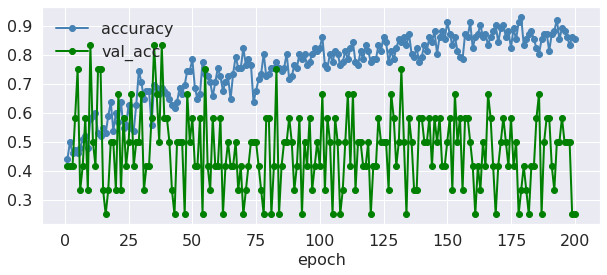

In [81]:
# Let's take a look at the accuracy values during the different epochs:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
        color="green", label="val_acc")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16)

In [82]:
# Evaluating the model

evaluation = model.evaluate(X_test, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

14/14 [==============================] - 0s 4ms/step
Loss in Test set:      0.41
Accuracy in Test set:  78.57


In [83]:
# Run more model iterations

nEpochs = 500

checkpointer = ModelCheckpoint(filepath="saved_models/best_model_500e.hdf5", verbose=1, save_best_only=True)
%time fit = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nEpochs, batch_size=batch_size, callbacks=[checkpointer])

Train on 102 samples, validate on 12 samples
Epoch 1/500
102/102 [==============================] - 1s 11ms/step - loss: 0.2888 - accuracy: 0.9020 - val_loss: 1.0266 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.02665, saving model to saved_models/best_model_500e.hdf5
Epoch 2/500
102/102 [==============================] - 1s 11ms/step - loss: 0.2503 - accuracy: 0.9118 - val_loss: 0.9210 - val_accuracy: 0.5833

Epoch 00002: val_loss improved from 1.02665 to 0.92102, saving model to saved_models/best_model_500e.hdf5
Epoch 3/500
102/102 [==============================] - 1s 10ms/step - loss: 0.3090 - accuracy: 0.8627 - val_loss: 1.3153 - val_accuracy: 0.4167

Epoch 00003: val_loss did not improve from 0.92102
Epoch 4/500
102/102 [==============================] - 1s 11ms/step - loss: 0.3061 - accuracy: 0.8725 - val_loss: 0.7850 - val_accuracy: 0.5000

Epoch 00004: val_loss improved from 0.92102 to 0.78498, saving model to saved_models/best_model_500e.hdf5
Epoch 5/50

102/102 [==============================] - 1s 10ms/step - loss: 0.2523 - accuracy: 0.9020 - val_loss: 0.7607 - val_accuracy: 0.5833

Epoch 00041: val_loss did not improve from 0.59185
Epoch 42/500
102/102 [==============================] - 1s 11ms/step - loss: 0.3129 - accuracy: 0.8431 - val_loss: 1.3318 - val_accuracy: 0.4167

Epoch 00042: val_loss did not improve from 0.59185
Epoch 43/500
102/102 [==============================] - 1s 10ms/step - loss: 0.2627 - accuracy: 0.9216 - val_loss: 0.7200 - val_accuracy: 0.6667

Epoch 00043: val_loss did not improve from 0.59185
Epoch 44/500
102/102 [==============================] - 1s 11ms/step - loss: 0.2663 - accuracy: 0.8725 - val_loss: 0.8710 - val_accuracy: 0.5000

Epoch 00044: val_loss did not improve from 0.59185
Epoch 45/500
102/102 [==============================] - 1s 10ms/step - loss: 0.2267 - accuracy: 0.9216 - val_loss: 0.6520 - val_accuracy: 0.5833

Epoch 00045: val_loss did not improve from 0.59185
Epoch 46/500
102/102 [======

102/102 [==============================] - 1s 11ms/step - loss: 0.2136 - accuracy: 0.9314 - val_loss: 0.7397 - val_accuracy: 0.5000

Epoch 00082: val_loss did not improve from 0.55856
Epoch 83/500
102/102 [==============================] - 1s 12ms/step - loss: 0.2548 - accuracy: 0.9216 - val_loss: 0.8659 - val_accuracy: 0.5000

Epoch 00083: val_loss did not improve from 0.55856
Epoch 84/500
102/102 [==============================] - 1s 12ms/step - loss: 0.1740 - accuracy: 0.9706 - val_loss: 1.1835 - val_accuracy: 0.5833

Epoch 00084: val_loss did not improve from 0.55856
Epoch 85/500
102/102 [==============================] - 1s 11ms/step - loss: 0.2090 - accuracy: 0.9314 - val_loss: 1.1799 - val_accuracy: 0.5000

Epoch 00085: val_loss did not improve from 0.55856
Epoch 86/500
102/102 [==============================] - 1s 12ms/step - loss: 0.2176 - accuracy: 0.9314 - val_loss: 1.0583 - val_accuracy: 0.2500

Epoch 00086: val_loss did not improve from 0.55856
Epoch 87/500
102/102 [======

102/102 [==============================] - 1s 11ms/step - loss: 0.1574 - accuracy: 0.9510 - val_loss: 1.6343 - val_accuracy: 0.5000

Epoch 00123: val_loss did not improve from 0.50124
Epoch 124/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1619 - accuracy: 0.9608 - val_loss: 1.1508 - val_accuracy: 0.5000

Epoch 00124: val_loss did not improve from 0.50124
Epoch 125/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1966 - accuracy: 0.9412 - val_loss: 1.1505 - val_accuracy: 0.4167

Epoch 00125: val_loss did not improve from 0.50124
Epoch 126/500
102/102 [==============================] - 1s 10ms/step - loss: 0.2043 - accuracy: 0.9412 - val_loss: 0.5474 - val_accuracy: 0.5833

Epoch 00126: val_loss did not improve from 0.50124
Epoch 127/500
102/102 [==============================] - 1s 11ms/step - loss: 0.2030 - accuracy: 0.9510 - val_loss: 1.2450 - val_accuracy: 0.5000

Epoch 00127: val_loss did not improve from 0.50124
Epoch 128/500
102/102 [=

102/102 [==============================] - 1s 11ms/step - loss: 0.1831 - accuracy: 0.9020 - val_loss: 0.4499 - val_accuracy: 0.8333

Epoch 00164: val_loss did not improve from 0.38925
Epoch 165/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1867 - accuracy: 0.9412 - val_loss: 0.5906 - val_accuracy: 0.6667

Epoch 00165: val_loss did not improve from 0.38925
Epoch 166/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1892 - accuracy: 0.9314 - val_loss: 1.3744 - val_accuracy: 0.4167

Epoch 00166: val_loss did not improve from 0.38925
Epoch 167/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1776 - accuracy: 0.9510 - val_loss: 0.6014 - val_accuracy: 0.6667

Epoch 00167: val_loss did not improve from 0.38925
Epoch 168/500
102/102 [==============================] - 1s 11ms/step - loss: 0.2320 - accuracy: 0.9216 - val_loss: 0.8081 - val_accuracy: 0.5000

Epoch 00168: val_loss did not improve from 0.38925
Epoch 169/500
102/102 [=

102/102 [==============================] - 1s 11ms/step - loss: 0.2148 - accuracy: 0.9020 - val_loss: 0.4106 - val_accuracy: 0.7500

Epoch 00205: val_loss did not improve from 0.38925
Epoch 206/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1843 - accuracy: 0.9314 - val_loss: 0.5281 - val_accuracy: 0.5833

Epoch 00206: val_loss did not improve from 0.38925
Epoch 207/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1640 - accuracy: 0.9608 - val_loss: 0.5034 - val_accuracy: 0.8333

Epoch 00207: val_loss did not improve from 0.38925
Epoch 208/500
102/102 [==============================] - 1s 11ms/step - loss: 0.2067 - accuracy: 0.9216 - val_loss: 1.2450 - val_accuracy: 0.4167

Epoch 00208: val_loss did not improve from 0.38925
Epoch 209/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1934 - accuracy: 0.9412 - val_loss: 0.6383 - val_accuracy: 0.6667

Epoch 00209: val_loss did not improve from 0.38925
Epoch 210/500
102/102 [=

102/102 [==============================] - 1s 11ms/step - loss: 0.1460 - accuracy: 0.9706 - val_loss: 0.7556 - val_accuracy: 0.5833

Epoch 00246: val_loss did not improve from 0.38925
Epoch 247/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1609 - accuracy: 0.9608 - val_loss: 0.5669 - val_accuracy: 0.6667

Epoch 00247: val_loss did not improve from 0.38925
Epoch 248/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1472 - accuracy: 0.9608 - val_loss: 1.0862 - val_accuracy: 0.5000

Epoch 00248: val_loss did not improve from 0.38925
Epoch 249/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1721 - accuracy: 0.9608 - val_loss: 0.4178 - val_accuracy: 0.6667

Epoch 00249: val_loss did not improve from 0.38925
Epoch 250/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1218 - accuracy: 0.9804 - val_loss: 1.0185 - val_accuracy: 0.5000

Epoch 00250: val_loss did not improve from 0.38925
Epoch 251/500
102/102 [=

102/102 [==============================] - 1s 11ms/step - loss: 0.1263 - accuracy: 0.9608 - val_loss: 0.7829 - val_accuracy: 0.4167

Epoch 00287: val_loss did not improve from 0.38925
Epoch 288/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1375 - accuracy: 0.9608 - val_loss: 1.0596 - val_accuracy: 0.5833

Epoch 00288: val_loss did not improve from 0.38925
Epoch 289/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1391 - accuracy: 0.9706 - val_loss: 0.4947 - val_accuracy: 0.6667

Epoch 00289: val_loss did not improve from 0.38925
Epoch 290/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1794 - accuracy: 0.9412 - val_loss: 0.7201 - val_accuracy: 0.5833

Epoch 00290: val_loss did not improve from 0.38925
Epoch 291/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1487 - accuracy: 0.9608 - val_loss: 0.8230 - val_accuracy: 0.5000

Epoch 00291: val_loss did not improve from 0.38925
Epoch 292/500
102/102 [=

102/102 [==============================] - 1s 11ms/step - loss: 0.1254 - accuracy: 0.9608 - val_loss: 0.9364 - val_accuracy: 0.5000

Epoch 00328: val_loss did not improve from 0.38925
Epoch 329/500
102/102 [==============================] - 1s 11ms/step - loss: 0.0981 - accuracy: 0.9706 - val_loss: 1.0002 - val_accuracy: 0.5833

Epoch 00329: val_loss did not improve from 0.38925
Epoch 330/500
102/102 [==============================] - 1s 10ms/step - loss: 0.1383 - accuracy: 0.9608 - val_loss: 0.4483 - val_accuracy: 0.7500

Epoch 00330: val_loss did not improve from 0.38925
Epoch 331/500
102/102 [==============================] - 1s 11ms/step - loss: 0.0951 - accuracy: 0.9902 - val_loss: 1.2514 - val_accuracy: 0.5000

Epoch 00331: val_loss did not improve from 0.38925
Epoch 332/500
102/102 [==============================] - 1s 10ms/step - loss: 0.1330 - accuracy: 0.9608 - val_loss: 0.6854 - val_accuracy: 0.5000

Epoch 00332: val_loss did not improve from 0.38925
Epoch 333/500
102/102 [=

102/102 [==============================] - 1s 10ms/step - loss: 0.1302 - accuracy: 0.9608 - val_loss: 0.7865 - val_accuracy: 0.5833

Epoch 00369: val_loss did not improve from 0.38925
Epoch 370/500
102/102 [==============================] - 1s 10ms/step - loss: 0.1012 - accuracy: 0.9608 - val_loss: 0.4801 - val_accuracy: 0.6667

Epoch 00370: val_loss did not improve from 0.38925
Epoch 371/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1036 - accuracy: 0.9902 - val_loss: 0.5913 - val_accuracy: 0.5833

Epoch 00371: val_loss did not improve from 0.38925
Epoch 372/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1364 - accuracy: 0.9706 - val_loss: 0.6085 - val_accuracy: 0.6667

Epoch 00372: val_loss did not improve from 0.38925
Epoch 373/500
102/102 [==============================] - 1s 11ms/step - loss: 0.0915 - accuracy: 0.9804 - val_loss: 0.7437 - val_accuracy: 0.5000

Epoch 00373: val_loss did not improve from 0.38925
Epoch 374/500
102/102 [=

102/102 [==============================] - 1s 11ms/step - loss: 0.0975 - accuracy: 0.9510 - val_loss: 0.6348 - val_accuracy: 0.6667

Epoch 00410: val_loss did not improve from 0.38925
Epoch 411/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1065 - accuracy: 0.9706 - val_loss: 0.5212 - val_accuracy: 0.6667

Epoch 00411: val_loss did not improve from 0.38925
Epoch 412/500
102/102 [==============================] - 1s 11ms/step - loss: 0.0983 - accuracy: 0.9706 - val_loss: 0.6306 - val_accuracy: 0.6667

Epoch 00412: val_loss did not improve from 0.38925
Epoch 413/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1077 - accuracy: 0.9706 - val_loss: 0.7055 - val_accuracy: 0.3333

Epoch 00413: val_loss did not improve from 0.38925
Epoch 414/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1014 - accuracy: 0.9804 - val_loss: 0.8636 - val_accuracy: 0.5000

Epoch 00414: val_loss did not improve from 0.38925
Epoch 415/500
102/102 [=

102/102 [==============================] - 1s 11ms/step - loss: 0.0831 - accuracy: 0.9804 - val_loss: 0.9395 - val_accuracy: 0.5833

Epoch 00451: val_loss did not improve from 0.38925
Epoch 452/500
102/102 [==============================] - 1s 11ms/step - loss: 0.1050 - accuracy: 0.9608 - val_loss: 0.6343 - val_accuracy: 0.5833

Epoch 00452: val_loss did not improve from 0.38925
Epoch 453/500
102/102 [==============================] - 1s 11ms/step - loss: 0.0800 - accuracy: 0.9902 - val_loss: 0.7866 - val_accuracy: 0.5833

Epoch 00453: val_loss did not improve from 0.38925
Epoch 454/500
102/102 [==============================] - 1s 11ms/step - loss: 0.0993 - accuracy: 0.9706 - val_loss: 0.6916 - val_accuracy: 0.6667

Epoch 00454: val_loss did not improve from 0.38925
Epoch 455/500
102/102 [==============================] - 1s 11ms/step - loss: 0.0938 - accuracy: 0.9804 - val_loss: 0.3783 - val_accuracy: 0.6667

Epoch 00455: val_loss improved from 0.38925 to 0.37825, saving model to sav

102/102 [==============================] - 1s 11ms/step - loss: 0.0910 - accuracy: 0.9804 - val_loss: 0.6189 - val_accuracy: 0.6667

Epoch 00492: val_loss did not improve from 0.37825
Epoch 493/500
102/102 [==============================] - 1s 10ms/step - loss: 0.0775 - accuracy: 0.9902 - val_loss: 0.8855 - val_accuracy: 0.5833

Epoch 00493: val_loss did not improve from 0.37825
Epoch 494/500
102/102 [==============================] - 1s 10ms/step - loss: 0.0874 - accuracy: 0.9804 - val_loss: 0.5024 - val_accuracy: 0.7500

Epoch 00494: val_loss did not improve from 0.37825
Epoch 495/500
102/102 [==============================] - 1s 11ms/step - loss: 0.0729 - accuracy: 0.9804 - val_loss: 0.6075 - val_accuracy: 0.6667

Epoch 00495: val_loss did not improve from 0.37825
Epoch 496/500
102/102 [==============================] - 1s 11ms/step - loss: 0.0867 - accuracy: 0.9608 - val_loss: 0.8329 - val_accuracy: 0.5000

Epoch 00496: val_loss did not improve from 0.37825
Epoch 497/500
102/102 [=

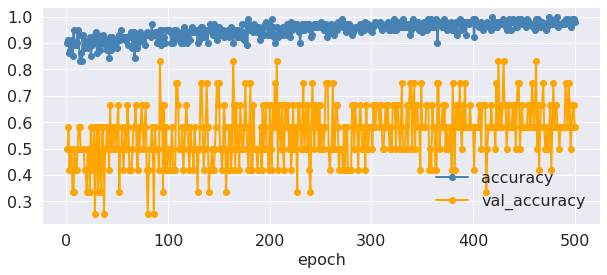

In [84]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
         color="orange", label="val_accuracy")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

In [85]:
# Wow, much better! At least on the training data. What about the test data?

evaluation = model.evaluate(X_test, y_test, verbose = 1)
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

14/14 [==============================] - 0s 4ms/step
Loss in Test set:      0.17
Accuracy in Test set:  92.86


In [86]:
# Analyze prediction values

y_pred = model.predict(X_test)
y_pred[:,:]

array([[3.6632098e-06, 9.9999630e-01],
       [4.9412775e-01, 5.0587231e-01],
       [2.4554554e-01, 7.5445437e-01],
       [3.8336515e-05, 9.9996161e-01],
       [3.5989877e-05, 9.9996400e-01],
       [5.3934669e-01, 4.6065328e-01],
       [2.9361188e-02, 9.7063881e-01],
       [5.4475689e-01, 4.5524308e-01],
       [9.5567822e-01, 4.4321805e-02],
       [5.7009095e-01, 4.2990899e-01],
       [9.8723376e-01, 1.2766308e-02],
       [7.8327578e-01, 2.1672420e-01],
       [9.9999881e-01, 1.1517237e-06],
       [6.6082597e-01, 3.3917409e-01]], dtype=float32)

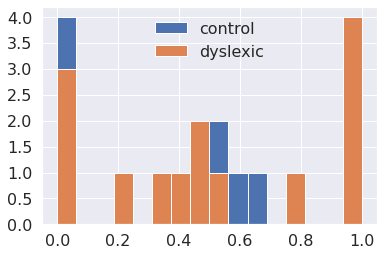

In [87]:
fig = plt.figure(figsize=(6, 4))
fontsize = 16
plt.hist(y_pred[:,0], bins=16, label='control')
plt.hist(y_pred[:,1], bins=16, label='dyslexic');
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

In [88]:
# Import confusion matrix and classification report from scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
Y_prediction = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(target[indexes_test], Y_pred_classes) 
print(classification_report(target[indexes_test], Y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14



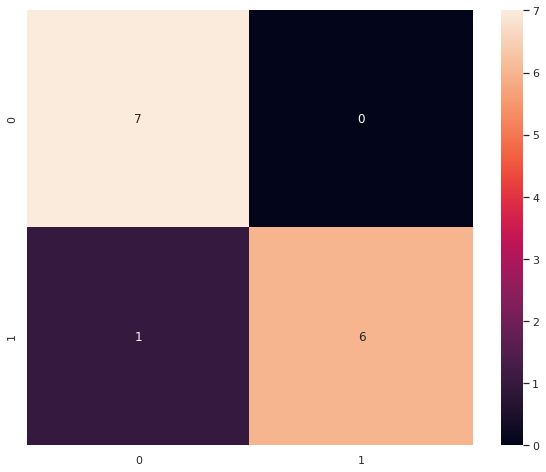

In [89]:
# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [35]:
# To run our 3D model we need to turn our 3D files into 4D
# For that we loop through our data and expand one dimension adding gray color to our files
masked_data =[]
for data in data_all:
    aux = np.expand_dims(np.array(data), axis=0)
    masked_data.append(aux)


images = np.asarray(masked_data)
print(images.shape)
images = np.rollaxis(images, 1, 5)
print(images.shape)

(128, 1, 60, 73, 60)
(128, 60, 73, 60, 1)


In [43]:
# Create list of indices
N = images.shape[0]
indexes = np.arange(N)

# Divide our dataset into dyslexics and controls to have a balanced train, validation and test sets
dis = indexes[:64]
con = indexes[64:]

#  Cut the dataset at 80% to create the training, 10% validation and 10% test set
size = dis.shape[0]
split_1 = int(0.8 * size)
split_2 = int(0.9 * size)

# Shuffle our dyslexics and controls arrays to create random indexes
np.random.shuffle(np.asarray(dis))
np.random.shuffle(np.asarray(con))

# Create our indexes for our train, validation and test sets according to our previous division (80%, 10%, 10%)
indexes_train_dis, indexes_train_con = dis[:split_1], con[:split_1]
indexes_val_dis, indexes_val_con   = dis[split_1:split_2], con[split_1:split_2]
indexes_test_dis, indexes_test_con = dis[split_2:], con[split_2:]

# We concatenate our training, validation and test indexes for dyslexics and controls
# By doing that we ensure that each set is balanced with the same number of dyslexics and controls
indexes_train = np.concatenate((indexes_train_dis, indexes_train_con), axis=None)
indexes_val = np.concatenate((indexes_val_dis, indexes_val_con), axis=None)
indexes_test = np.concatenate((indexes_test_dis, indexes_test_con), axis=None)


# Split the data into training, validation and test sets according to the indexes created previously
X_train = images[indexes_train, ...]
X_val = images[indexes_val, ...]
X_test = images[indexes_test, ...]

In [40]:
# Create outcome variable for each set (training, validation and test)
# The same as for our 2D example
y_train = target[indexes_train] 
y_val   = target[indexes_val]
y_test  = target[indexes_test]

In [41]:
# We need to reformat the shape of our outcome variables, y_train, y_dev and y_test, because Keras needs the labels 
# as a 2D array. Keras provides a function to do this:

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Here we check the final distribution of our sets and its shape
# It is also possible to check if the labels became categorical (the second dimension in our arrays)
print(y_train.shape)
print(y_train[2])
print(y_test.shape)
print(y_val.shape)

(102, 2)
[0. 1.]
(14, 2)
(12, 2)


In [64]:
from keras.layers import Conv3D, MaxPooling3D, AveragePooling3D

In [42]:
# Get shape of input data
data_shape = tuple(X_train.shape[1:])
print(data_shape)

# Specify shape of convolution kernel
kernel_size = (3, 3, 3)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 16 

(60, 73, 60, 1)


In [44]:
# Create modified LeNet Model
K.clear_session()
model = Sequential()

model.add(Conv3D(filters, kernel_size, activation='relu', input_shape=data_shape,
                 strides=(3, 3, 3)))
model.add(BatchNormalization())
model.add(MaxPooling3D())

model.add(Conv3D(filters * 2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters * 4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

# optimizer
learning_rate = 1e-5
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 24, 20, 16)    448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 24, 20, 16)    64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 12, 10, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 10, 8, 32)      13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 10, 8, 32)      128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 5, 4, 32)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 3, 2, 64)      

In [60]:
# Converting one of our GGP deep learning architecture to a 3D model
K.clear_session()
model = Sequential()

model.add(Conv3D(32, kernel_size=(4,4,4), activation='sigmoid', input_shape=data_shape,
                 strides=(1, 1, 1), padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling3D(pool_size=(3,3,3), strides=(2,2,2), padding='same'))

model.add(Conv3D(128, kernel_size=(3,3,3), strides=(2,2,2), activation='relu', use_bias=True, padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling3D(pool_size=(3, 3, 3), strides=(2,2,2), padding='same'))
#model.add(AveragePooling3D(pool_size=(5, 5, 5), strides=(2,2,2), padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(1,1,1), padding='same'))

model.add(Conv3D(128, kernel_size=(4,4,4), strides=(1,1,1), activation='linear', padding='valid', use_bias=True))
model.add(BatchNormalization())
model.add(Conv3D(32, kernel_size=(2,2,2), strides=(3,3,3), activation='linear', padding='valid', use_bias=True))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(512, activation='linear'))
model.add(Dropout(0.8))

model.add(Dense(2, activation='softmax'))

# optimizer
learning_rate = 0.0001
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 60, 73, 60, 32)    2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 73, 60, 32)    128       
_________________________________________________________________
average_pooling3d_1 (Average (None, 30, 37, 30, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 19, 15, 128)   110720    
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 19, 15, 128)   512       
_________________________________________________________________
average_pooling3d_2 (Average (None, 8, 10, 8, 128)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 10, 8, 128)    

In [61]:
# Fitting the model
nEpochs = 50
batch_size = 8

In [50]:
# TensorBoard callback
LOG_DIRECTORY_ROOT = 'logdir'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

In [62]:
# Adding ModelCheckPoint callback
checkpointer = keras.callbacks.ModelCheckpoint(filepath='saved_models/best_3D_GGP.hdf5', verbose=1, save_best_only=True)

# Place the callbacks in a list
callback_list = [tensorboard, checkpointer]

In [63]:
fit = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nEpochs, batch_size=batch_size, verbose=1, callbacks=callback_list)

Train on 102 samples, validate on 12 samples
Epoch 1/50
102/102 [==============================] - 104s 1s/step - loss: 1.4708 - accuracy: 0.4706 - val_loss: 0.7726 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.77264, saving model to saved_models/best_3D_GGP.hdf5
Epoch 2/50
102/102 [==============================] - 103s 1s/step - loss: 0.8958 - accuracy: 0.6078 - val_loss: 0.6833 - val_accuracy: 0.5000

Epoch 00002: val_loss improved from 0.77264 to 0.68331, saving model to saved_models/best_3D_GGP.hdf5
Epoch 3/50
102/102 [==============================] - 104s 1s/step - loss: 0.6835 - accuracy: 0.6471 - val_loss: 0.6916 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.68331
Epoch 4/50
102/102 [==============================] - 104s 1s/step - loss: 0.8123 - accuracy: 0.5686 - val_loss: 0.6892 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.68331
Epoch 5/50
102/102 [==============================] - 102s 1s/step - loss: 0.

102/102 [==============================] - 103s 1s/step - loss: 0.2481 - accuracy: 0.8824 - val_loss: 0.4871 - val_accuracy: 0.7500

Epoch 00039: val_loss did not improve from 0.46205
Epoch 40/50
102/102 [==============================] - 104s 1s/step - loss: 0.2689 - accuracy: 0.8922 - val_loss: 0.4745 - val_accuracy: 0.7500

Epoch 00040: val_loss did not improve from 0.46205
Epoch 41/50
102/102 [==============================] - 102s 1s/step - loss: 0.3100 - accuracy: 0.8333 - val_loss: 0.4294 - val_accuracy: 0.7500

Epoch 00041: val_loss improved from 0.46205 to 0.42938, saving model to saved_models/best_3D_GGP.hdf5
Epoch 42/50
102/102 [==============================] - 103s 1s/step - loss: 0.3297 - accuracy: 0.8431 - val_loss: 0.4409 - val_accuracy: 0.8333

Epoch 00042: val_loss did not improve from 0.42938
Epoch 43/50
102/102 [==============================] - 102s 1s/step - loss: 0.2978 - accuracy: 0.8725 - val_loss: 0.4049 - val_accuracy: 0.8333

Epoch 00043: val_loss improved f

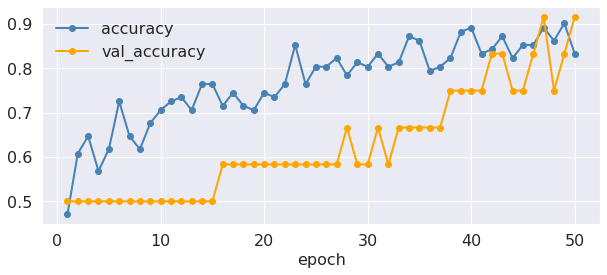

In [65]:
# Performance during model fitting
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2,
             color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
             color="orange", label="val_accuracy")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16)

In [66]:
# Evaluating the model
#if run_3D_convnet:
evaluation = model.evaluate(X_test, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

14/14 [==============================] - 2s 123ms/step
Loss in Test set:      0.57
Accuracy in Test set:  64.29


In [67]:
from sklearn.metrics import confusion_matrix, classification_report
Y_prediction = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(target[indexes_test], Y_pred_classes) 
print(classification_report(target[indexes_test], Y_pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.62      0.71      0.67         7

    accuracy                           0.64        14
   macro avg       0.65      0.64      0.64        14
weighted avg       0.65      0.64      0.64        14



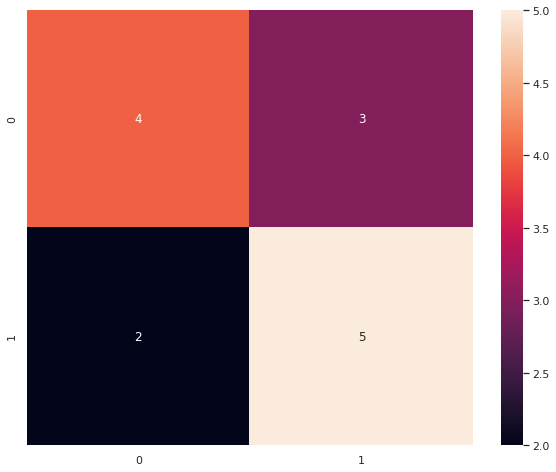

In [68]:
# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");